In [ ]:
!pip install pytorch-forecasting

In [2]:
import torch
import torch.nn.functional as F
#from mtgnn import MTGNN
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

#from pytorch_forecasting.metrics.point import MAPE

from IPython.display import clear_output

In [ ]:
def root_relative_squared_error(y_true, predictions):
  """
  y_true: np.2darray (n_samples, n_outputs)
  predictions: np.2darray (n_samples, n_outputs)
  """

  return np.sqrt(((y_true - predictions)**2).sum(0) / ((y_true - y_true.mean(0))**2).sum(0)).mean()

## High frequency data

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_losses(train_losses, test_losses, train_mape, test_mape):
    clear_output()

    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('MSELoss')

    axs[1].plot(range(1, len(train_mape) + 1), train_mape, label='train')
    axs[1].plot(range(1, len(test_mape) + 1), test_mape, label='test')
    axs[1].set_ylabel('mape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

torch.autograd.set_detect_anomaly(True)
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_mape = 0.0, 0.0
    mape = MAPE()
    model.train()
    for series, target in tqdm(train_loader, desc=tqdm_desc):
        series = series.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        prediction = model(series)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * series.shape[0]
        train_mape += mape.loss(target, prediction).sum().item()
    train_loss /= len(train_loader.dataset)
    train_mape /= len(train_loader.dataset)

    return train_loss, train_mape

@torch.no_grad() # декоратор перед функцией позволяет не считать градиенты
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    mape = MAPE()
    test_loss, test_mape = 0.0, 0.0
    model.eval()
    for series, target in tqdm(test_loader, desc=tqdm_desc):
        series = series.to(device)
        target = target.to(device)

        prediction = model(series)
        loss = criterion(prediction, target)

        test_loss += loss.item() * series.shape[0]
        test_mape += mape.loss(target, prediction).sum().item()
    test_loss /= len(test_loader.dataset)
    test_mape /= len(test_loader.dataset)
    return test_loss, test_mape


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, early_stopping_rouds):
    train_losses, train_mapes = [], []
    test_losses, test_mapes = [], []

    best_metric = np.inf
    for epoch in range(1, num_epochs + 1):
      if early_stopping_rouds != 0:
        train_loss, train_mape = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_mape = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        if test_mape > best_metric:
          early_stopping_rouds -= 1
        else:
          best_params = model.parameters()
          best_metric = test_mape

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_mapes += [train_mape]
        test_losses += [test_loss]
        test_mapes += [test_mape]
        plot_losses(train_losses, test_losses, train_mapes, test_mapes)

    return train_losses, test_losses, train_mapes, test_mapes, best_params

In [ ]:
class MTGNN_Dataset(Dataset):
  '''
  For each index returns
  x: [1, num_nodes, seq_len]
  y: [1, num_nodes, 1]
  '''
  def __init__(self, ts, seq_len):
    super().__init__()
    self.ts = ts
    self.y = ts[seq_len:, :]
    self.seq_len = seq_len
    self.total_len, self.m = ts.size()


    # Проверяем, что seq_len меньше или равен total_len
    if self.seq_len > self.total_len:
        raise ValueError("seq_len should be less than or equal to total_len")

    # Number of observations
    self.n = self.total_len - self.seq_len

  def __getitem__(self, index):

    return self.ts[index:index+self.seq_len, :].transpose(1,0)[None, ...], self.y[index, :][None, ..., None]

  def __len__(self):
    return self.n

## Для первого ряда

In [3]:
df = pd.read_csv('ticker.spot.csv')[['bid_price',	'bid_amount',	'ask_price',	'ask_amount']]

Комментарий: Z-стандартизация показала себя лучше, чем Min-Max. Вторая иногда вызывает взрыв градиентов, хотя для правильного шкалирования нужно использовать именно Min-Max, заранее позаботясь о выбросах.

In [ ]:
def normalize_ts(ts):
  '''
  Z - standartization for miltivariate time series
  ts: torch.Tensor[ts_len, num_nodes]
  '''
  normalized_ts = (ts - ts.mean(dim=0)) / (ts.std(dim=0))
  return normalized_ts

In [ ]:
ts = normalize_ts(torch.FloatTensor(df.values)[:11000,:])
ts_train, ts_test = ts[:10000, :], ts[10000:11000, :]

In [ ]:
train_dataset = MTGNN_Dataset(ts_train, 500)
test_dataset = MTGNN_Dataset(ts_test, 500)
train_loader = DataLoader(train_dataset, batch_size = 100)
test_loader = DataLoader(test_dataset)

In [ ]:
model = MTGNN(gcn_true = True,
    build_adj = True,
    dropout = 0.3,
    subgraph_size = 2,
    gcn_depth = 2,
    num_nodes = 4,
    node_dim = 1,
    dilation_exponential = 1,
    conv_channels = 8,
    residual_channels = 32,
    skip_channels = 64,
    end_channels = 128,
    in_dim = 1,
    seq_length = 500,
    layers = 3,
    propalpha = 0.05,
    tanhalpha = 3,
    kernel_size = 7,
    kernel_set = [2, 3, 6, 7],
    layer_norm_affline=True,
    out_dim = 4)
model.to(device);

In [ ]:
num_epochs = 20
optimizer = Adam(model.parameters())
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # scheduler для настройки динамического lr

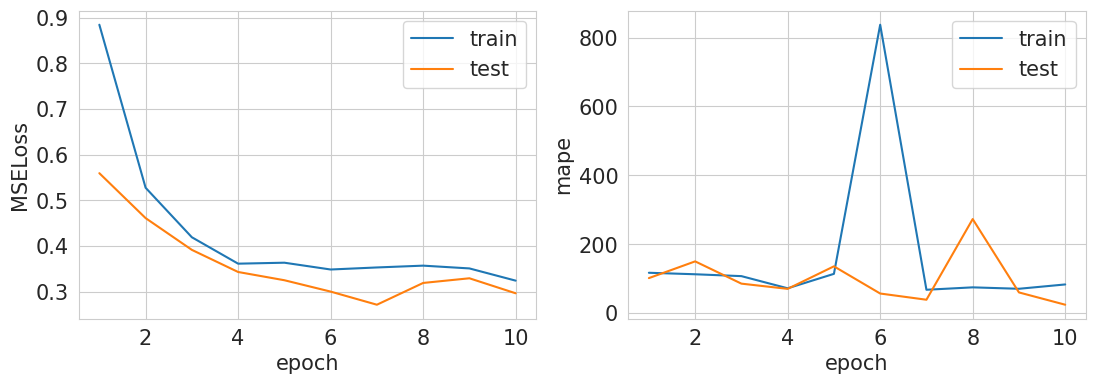

In [ ]:
_,_,_,_, best_params = train(model, optimizer, scheduler = None, \
      criterion = criterion, train_loader = train_loader, \
      test_loader = test_loader, num_epochs = num_epochs, early_stopping_rouds=5)

In [ ]:
predictions = []
y_true = []
with torch.no_grad():
  for x, y in test_loader:
    x,y = x.to(device), y.to(device)
    model.eval()
    predictions.append(model(x)[0,0, :,:])
    y_true.append(y[0,0, :,:])

y_true = np.array([element.reshape(-1).cpu().numpy() for element in y_true])
predictions = np.array([element.reshape(-1).cpu().numpy() for element in predictions])

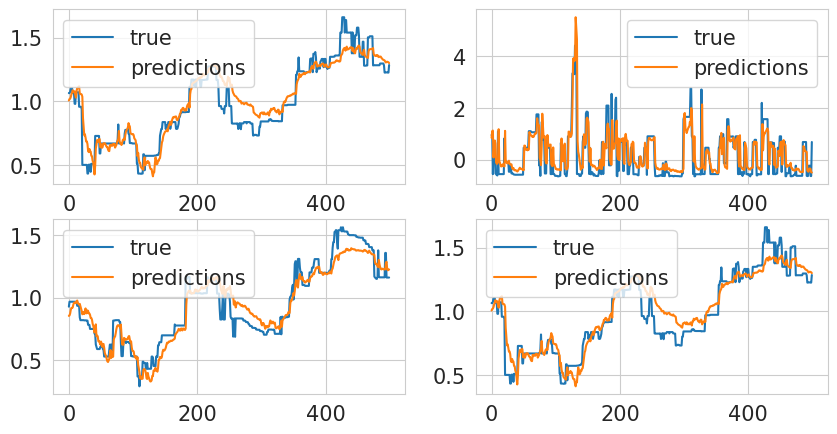

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (10,5))

ax[0,0].plot(y_true[:,0], label = 'true')
ax[0,0].plot(predictions[:,0], label = 'predictions')
ax[0,0].legend()

ax[0,1].plot(y_true[:,1], label = 'true')
ax[0,1].plot(predictions[:,1], label = 'predictions')
ax[0,1].legend()

ax[1,0].plot(y_true[:,2], label = 'true')
ax[1,0].plot(predictions[:,2], label = 'predictions')
ax[1,0].legend()

ax[1,1].plot(y_true[:,0], label = 'true')
ax[1,1].plot(predictions[:,0], label = 'predictions')
ax[1,1].legend();

In [ ]:
def validate_model(y_true, predictions):

  mape = mean_absolute_percentage_error(y_true, predictions)
  mse = mean_squared_error(y_true, predictions)
  rmse = np.sqrt(mse)
  rrse = root_relative_squared_error(y_true, predictions)

  (n,m) = y_true.shape
  corr = 0
  for i in range(m):
    corr += np.corrcoef(y_true[:,i], predictions[:,i])[1,0]

  corr /= m

  return mape, mse, rmse, rrse, corr


def print_metrics(mape, mse, rmse, rrse, corr):

  print('MAPE:', mape)
  print('MSE:', mse)
  print('RMSE:', rmse)
  print('RRSE:', rrse)
  print('Correlation coef:', corr)

In [ ]:
print_metrics(*validate_model(y_true, predictions))

MAPE: 0.46296686
MSE: 0.2627155
RMSE: 0.5125578
RRSE: 0.5259136
Correlation coef: 0.8278372007923586


## Для маленьких рядов

### Код объединения датасета

In [ ]:
# Здесь было удобнее подключиться к гугл драйв
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# объединю в один файл для удобства
import os

PATH = 'drive/MyDrive/financial_time_series/small_datasets'
file_names = os.listdir(PATH)[:-1]

proxi = False
for file_name in file_names:
  if not proxi:
    final_df = pd.read_csv(os.path.join(PATH, file_name))[['TRADEDATE', 'CLOSE']]
    final_df['TRADEDATE'] = pd.to_datetime(final_df['TRADEDATE'])
    proxi = True
  else:
    df = pd.read_csv(os.path.join(PATH, file_name))[['TRADEDATE', 'CLOSE']]
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    final_df = pd.merge(final_df, df, on = 'TRADEDATE', how = 'inner', suffixes = (None, f'_{file_name[:-4]}'))



In [ ]:
final_df[final_df == 0] = np.nan
final_df = final_df.fillna(method = 'ffill').fillna(method = 'bfill')
final_df.to_csv('final_dataset.csv')

### Обучение модели

In [ ]:
ts = normalize_ts(torch.FloatTensor(final_df.drop('TRADEDATE', axis = 1).values))
ts_train, ts_test = ts[:-100, :], ts[-100:, :]

In [ ]:
seq_len = 30
train_dataset = MTGNN_Dataset(ts_train, seq_len)
test_dataset = MTGNN_Dataset(ts_test, seq_len)
train_loader = DataLoader(train_dataset, batch_size = 30)
test_loader = DataLoader(test_dataset)

In [ ]:
model = MTGNN(gcn_true = True,
    build_adj = True,
    dropout = 0.3,
    subgraph_size = 3,
    gcn_depth = 2,
    num_nodes = ts_train.shape[1],
    node_dim = 1,
    dilation_exponential = 1,
    conv_channels = 8,
    residual_channels = 32,
    skip_channels = 64,
    end_channels = 128,
    in_dim = 1,
    seq_length = seq_len,
    layers = 5,
    propalpha = 0.05,
    tanhalpha = 3,
    kernel_size = 7,
    kernel_set = [2, 3, 6, 7],
    layer_norm_affline=True,
    out_dim = 4)
model.to(device);

In [ ]:
num_epochs = 40
optimizer = Adam(model.parameters())
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # scheduler для настройки динамического lr


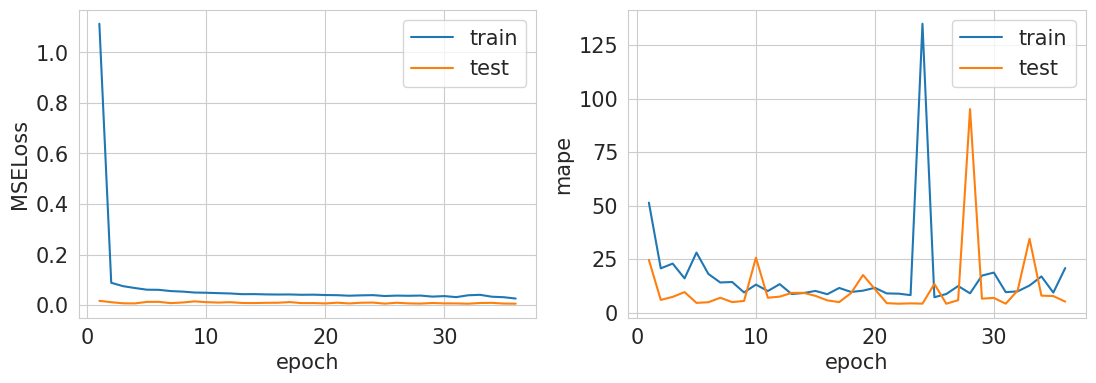

In [ ]:
_,_,_,_, best_params = train(model, optimizer, scheduler = None, \
      criterion = criterion, train_loader = train_loader, \
      test_loader = test_loader, num_epochs = num_epochs, early_stopping_rouds=30)

In [ ]:
predictions = []
y_true = []
with torch.no_grad():
  for x, y in test_loader:
    x,y = x.to(device), y.to(device)
    model.eval()
    predictions.append(model(x)[0,0, :,:])
    y_true.append(y[0,0, :,:])

y_true = np.array([element.reshape(-1).cpu().numpy() for element in y_true])
predictions = np.array([element.reshape(-1).cpu().numpy() for element in predictions])

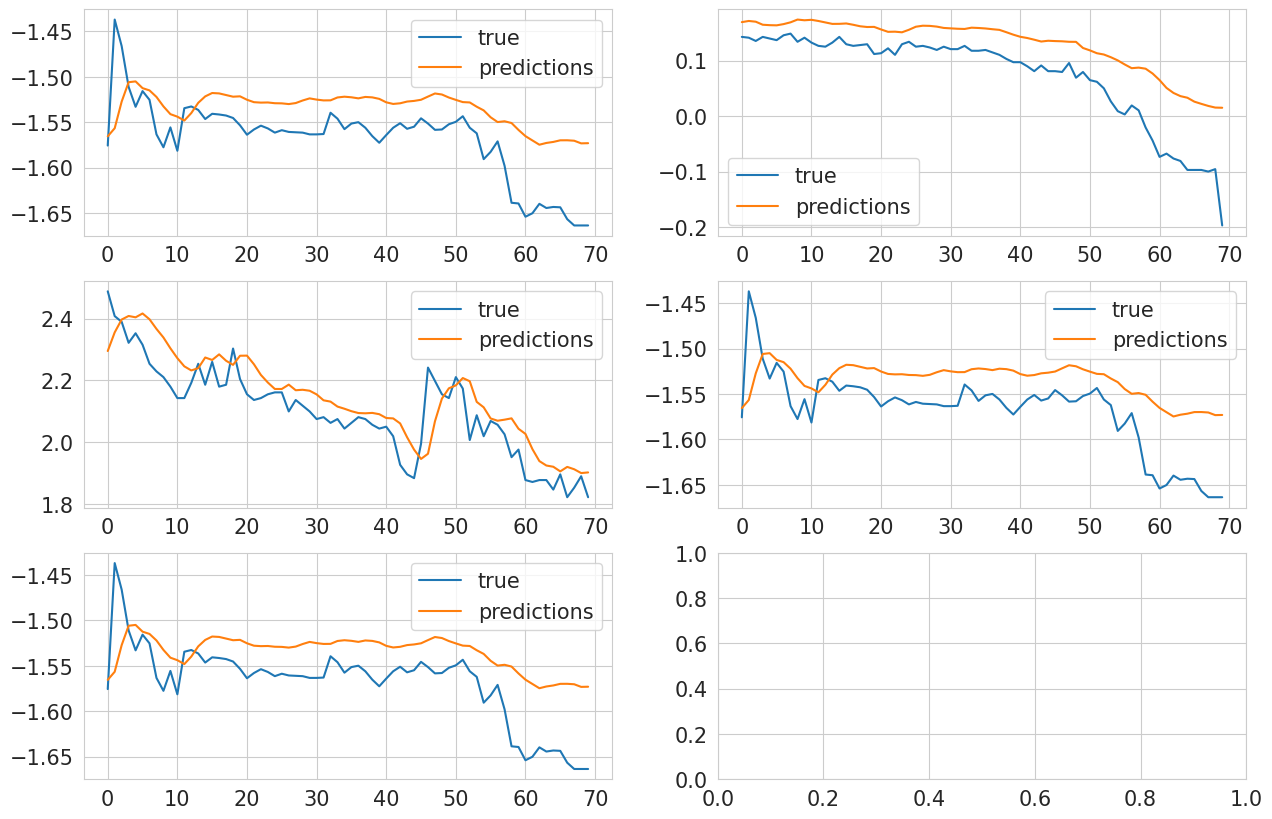

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (15,10))

ax[0,0].plot(y_true[:,0], label = 'true')
ax[0,0].plot(predictions[:,0], label = 'predictions')
ax[0,0].legend()

ax[0,1].plot(y_true[:,1], label = 'true')
ax[0,1].plot(predictions[:,1], label = 'predictions')
ax[0,1].legend()

ax[1,0].plot(y_true[:,2], label = 'true')
ax[1,0].plot(predictions[:,2], label = 'predictions')
ax[1,0].legend()

ax[1,1].plot(y_true[:,0], label = 'true')
ax[1,1].plot(predictions[:,0], label = 'predictions')
ax[1,1].legend()

ax[2,0].plot(y_true[:,0], label = 'true')
ax[2,0].plot(predictions[:,0], label = 'predictions')
ax[2,0].legend()

In [ ]:
print_metrics(*validate_model(y_true, predictions))

MAPE: 0.3117344
MSE: 0.0043272967
RMSE: 0.06578219
RRSE: 0.9740782
Correlation coef: 0.7988964085151267
